# Exercise 2

Modern camera with complete square pixels $\rarr$ Skew parameters $\alpha=1, \beta=0$


In [18]:
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
from util_functions import camera_intrinsic, project_points, box3d, Pi, PiInv

matplotlib.use("TkAgg")

%matplotlib inline

In [19]:
# Ex 2.1
f = 600
a = 1
b = 0
deltax = 400
deltay = 400
# resolution = 800x800, assuming principal point is the middle of the image

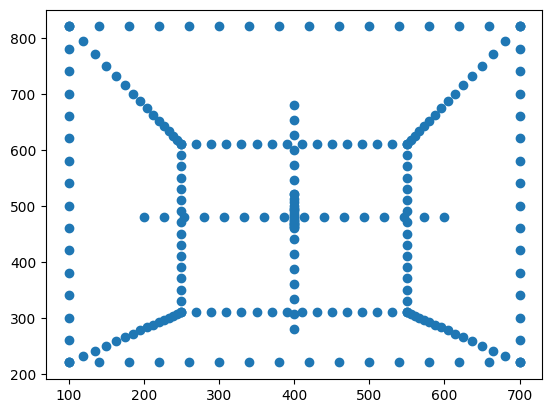

In [20]:
K = camera_intrinsic(f, (deltax, deltay), a, b)
R = np.eye(3)
t = np.array([0, 0.2, 1.5]).reshape(-1, 1)
Q = box3d()  # 3x240 matrix

P = project_points(K, R, t, Q)
plt.scatter(P[0, :], P[1, :])
plt.show()
# No, not all points are captured by the image sensor. The top part of
# the box is cut off as the coordinates are beyond 800.

In [21]:
P1 = np.array([-0.5, -0.5, -0.5]).reshape(-1, 1)

print(f"P1 is projected to {project_points(K, R, t, P1).T}")

P1 is projected to [[100. 220.]]


In [22]:
# Ex 2.2
def distort(q, distCoeffs):
    """
    Apply distortion to a 2D point on the image plane
    q: 2 x n, 2D points matrix
    """
    r = np.sqrt((q[0]) ** 2 + (q[1]) ** 2)
    correction = 1
    for i in range(len(distCoeffs)):
        exp = 2 * (i + 1)
        correction += distCoeffs[i] * r**exp
    qd = q * correction
    return qd


def project_points(K, R, t, Q, distCoeffs=[]):
    """
    Project 3D points in Q onto a 2D plane of a camera with distortion.

    K : 3 x 3, intrinsic camera matrix
    R : 3 x 3, rotation matrix
    t: 3 x 1, translation matrix
    Q: 3 x n, 3D points matrix
    distCoeffs: [k3,k5,k7,...] distortion coefficients

    P : 2 x n, 2D points matrix
    """
    Qh = PiInv(Q)  # 4 x n
    Rt = np.hstack((R, t))  # 3 x 4
    qh = Rt @ Qh  # 3 x n
    q = Pi(qh)  # 2 x n
    qd = distort(q, distCoeffs)  # 2 x n
    Ph = K @ PiInv(qd)  # 3 x n
    P = Pi(Ph)  # 2 x n
    return P

In [23]:
# Breakdown of applying distortion to a single 3D point

# Project 3D point into a 2D point on the image plane
P1 = np.array([-0.5, -0.5, -0.5]).reshape(-1, 1)
Rt = np.hstack((R, t))  # 3 x 4
ph = Rt @ PiInv(P1)  # 3 x 1
p = Pi(ph)  # 2 x 1
print(f"3D Point {P1.T} is projected onto {p.T} before distortion.")

# Apply distortion to the 2D point on image plane
distCoeffs = [-0.2, 0, 0]
pd = distort(p, distCoeffs)
print(f"2D point {p.T} is distorted to {pd.T} on image plane.")

# Project distorted 2D point into pixel coordinates
pdh = PiInv(pd)
qd = K @ pdh  # pixel coordinates
print(f"Distorted point {pd.T} is projected to {qd.T} after distortion.")

3D Point [[-0.5 -0.5 -0.5]] is projected onto [[-0.5 -0.3]] before distortion.
2D point [[-0.5 -0.3]] is distorted to [[-0.466  -0.2796]] on image plane.
Distorted point [[-0.466  -0.2796]] is projected to [[120.4  232.24   1.  ]] after distortion.


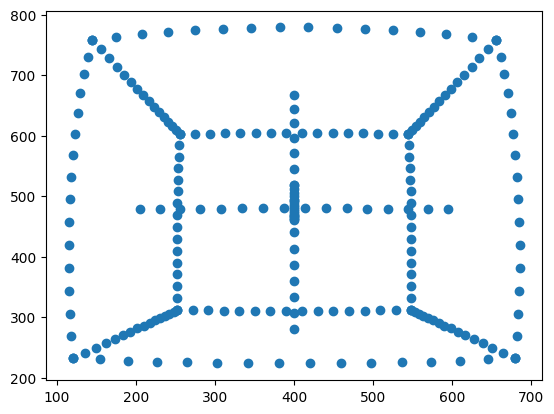

In [24]:
# Applying distortion to many 3D points

K = camera_intrinsic(f, (deltax, deltay), a, b)
R = np.eye(3)
t = np.array([0, 0.2, 1.5]).reshape(-1, 1)
Q = box3d()  # 3x240 matrix

P = project_points(K, R, t, Q, distCoeffs)
plt.scatter(P[0, :], P[1, :])
plt.show()
# Yes, all points are captured by the image sensor as all points
# lie within the 800x800 resolution.

In [25]:
# Ex 2.3

# camera parameters for gopro
gopro_im = cv2.imread("media/gopro_robot.jpg")[:, :, ::-1]
gopro_im = gopro_im.astype(float) / 255
f = 0.455732 * gopro_im.shape[1]
a = 1
b = 0
gopro_distCoeffs = [-0.245031, 0.071524, -0.00994978]
gopro_K = camera_intrinsic(
    f, (gopro_im.shape[1] / 2, gopro_im.shape[0] / 2), a, b
)
print(gopro_K)

[[875.00544   0.      960.     ]
 [  0.      875.00544 540.     ]
 [  0.        0.        1.     ]]


In [26]:
# Ex 2.4
def undistortImage(im, distCoeffs, K):
    # meshgrid: placeholder for pixel coordinates
    x, y = np.meshgrid(np.arange(im.shape[1]), np.arange(im.shape[0]))
    p = np.stack((x, y, np.ones(x.shape))).reshape(3, -1)  # 3 x n, homogenous

    q = Pi(np.linalg.inv(K) @ p)  # 2 x n
    qd = distort(q, distCoeffs)  # 2 x n
    p_d = K @ PiInv(qd)  # 3 x n

    x_d = p_d[0].reshape(x.shape).astype(np.float32)
    y_d = p_d[1].reshape(y.shape).astype(np.float32)
    assert (p_d[2] == 1).all(), "You did a mistake somewhere"
    # use bilinear interpolation to remap the image
    im_undistorted = cv2.remap(im, x_d, y_d, cv2.INTER_LINEAR)
    return im_undistorted

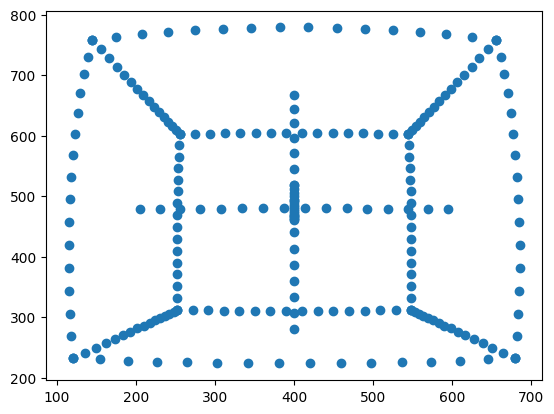

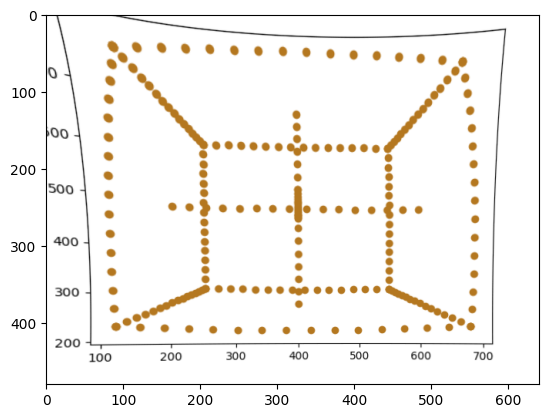

In [27]:
P = project_points(K, R, t, Q, distCoeffs)
plt.scatter(P[0, :], P[1, :])
plt.savefig("media/distorted_box3d.png")
plt.show()

im = cv2.imread("media/distorted_box3d.png")
undistored_im = undistortImage(im, distCoeffs, K)
plt.imshow(undistored_im)

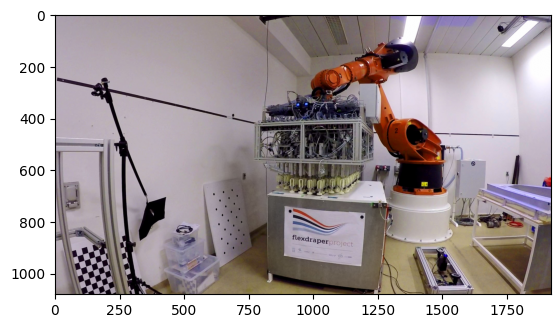

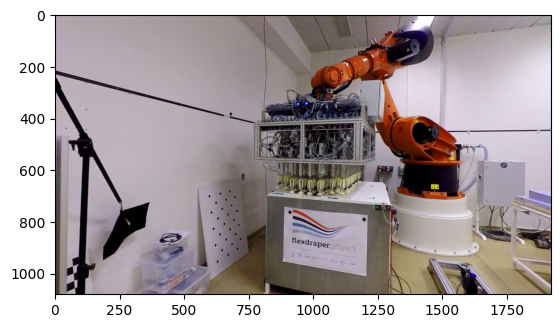

In [28]:
plt.imshow(gopro_im)
plt.show()

undistored_im = undistortImage(gopro_im, gopro_distCoeffs, gopro_K)
plt.imshow(undistored_im)
plt.show()

In [29]:
# Ex 2.5
p2a = np.array([1, 1]).reshape(-1, 1)
p2b = np.array([0, 3]).reshape(-1, 1)
p2c = np.array([2, 3]).reshape(-1, 1)
p2d = np.array([2, 4]).reshape(-1, 1)
H = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])
p2 = np.hstack((p2a, p2b, p2c, p2d))

# Apply homography to 2D points
qh = H @ PiInv(p2)  # 3 x n
q = Pi(qh)  # 2 x n
q

array([[-0.33333333,  0.33333333, -1.        , -1.        ],
       [-0.33333333, -2.        , -1.33333333, -2.        ]])

In [30]:
# Ex 2.6
def hest(q1, q2):
    """
    Calculate the homography matrix from n sets of 2D points
    q1 : 2 x n, 2D points in the first image
    q2 : 2 x n, 2D points in the second image
    H : 3 x 3, homography matrix
    """
    n = q1.shape[1]
    B = []
    for i in range(n):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array(
            [
                [0, -x2, x2 * y1, 0, -y2, y2 * y1, 0, -1, y1],
                [x2, 0, -x2 * x1, y2, 0, -y2 * x1, 1, 0, -x1],
                [-x2 * y1, x2 * x1, 0, -y2 * y1, y2 * x1, 0, -y1, x1, 0],
            ]
        )
        B.append(Bi)
    B = np.array(B).reshape(-1, 9)
    U, S, Vt = np.linalg.svd(B)
    H = Vt[-1].reshape(3, 3)
    return H.T


H = hest(q, p2)
with np.printoptions(precision=3, suppress=True):
    print(H)
# If the input points are flipped, inv(H) will be obtained.

[[ 0.459 -0.    -0.229]
 [-0.229  0.459  0.   ]
 [ 0.    -0.    -0.688]]


In [14]:
# H obtained in 2.6 should be equivalent to 2.5 (multiplied by scalar)
H = np.array([[-2, 0, 1], [1, -2, 0], [0, 0, 3]])
norm = np.linalg.norm(H, "fro")
H / norm

array([[-0.45883147,  0.        ,  0.22941573],
       [ 0.22941573, -0.45883147,  0.        ],
       [ 0.        ,  0.        ,  0.6882472 ]])

In [62]:
# Ex 2.7
def normalize2d(q):
    """
    Normalize 2D points.

    q : 2 x n, 2D points
    qn : 2 x n, normalized 2D points
    """
    if q.shape[0] != 2:
        raise ValueError("q must have 2 rows")
    if q.shape[1] < 2:
        raise ValueError("At least 2 points are required to normalize")

    mu = np.mean(q, axis=1).reshape(-1, 1)
    mu_x = mu[0].item()
    mu_y = mu[1].item()
    std = np.std(q, axis=1).reshape(-1, 1)
    std_x = std[0].item()
    std_y = std[1].item()
    Tinv = np.array([[std_x, 0, mu_x], [0, std_y, mu_y], [0, 0, 1]])
    T = np.linalg.inv(Tinv)
    qn = T @ PiInv(q)
    qn = Pi(qn)
    return qn, T


normalize2d(p2)

(array([[-0.30151134, -1.50755672,  0.90453403,  0.90453403],
        [-1.60591014,  0.22941573,  0.22941573,  1.14707867]]),
 array([[ 1.20604538,  0.        , -1.50755672],
        [ 0.        ,  0.91766294, -2.52357307],
        [ 0.        ,  0.        ,  1.        ]]))

In [63]:
# Ex 2.8
# Include normalization in the homography estimation
def hest(q1, q2, normalize=False):
    """
    Calculate the homography matrix from n sets of 2D points
    q1 : 2 x n, 2D points in the first image
    q2 : 2 x n, 2D points in the second image
    H : 3 x 3, homography matrix
    """
    if q1.shape[1] != q2.shape[1]:
        raise ValueError("Number of points in q1 and q2 must be equal")
    if q1.shape[1] < 4:
        raise ValueError(
            "At least 4 points are required to estimate a homography"
        )
    if q1.shape[0] != 2 or q2.shape[0] != 2:
        raise ValueError("q1 and q2 must have 2 rows")

    if normalize:
        q1, T1 = normalize2d(q1)
        q2, T2 = normalize2d(q2)

    n = q1.shape[1]
    B = []
    for i in range(n):
        x1, y1 = q1[:, i]
        x2, y2 = q2[:, i]
        Bi = np.array(
            [
                [0, -x2, x2 * y1, 0, -y2, y2 * y1, 0, -1, y1],
                [x2, 0, -x2 * x1, y2, 0, -y2 * x1, 1, 0, -x1],
                [-x2 * y1, x2 * x1, 0, -y2 * y1, y2 * x1, 0, -y1, x1, 0],
            ]
        )
        B.append(Bi)
    # with np.printoptions(precision=3, suppress=True):
    #     print("B:", B)
    B = np.array(B).reshape(-1, 9)
    U, S, Vt = np.linalg.svd(B)
    H = Vt[-1].reshape(3, 3)
    H = H.T
    if normalize:
        H = np.linalg.inv(T1) @ H @ T2
    return H


H = hest(q, p2, normalize=True)
with np.printoptions(precision=3, suppress=True):
    print("H: \n", H)

H: 
 [[ 0.367  0.    -0.184]
 [-0.184  0.367 -0.   ]
 [-0.    -0.    -0.551]]


In [61]:
# Ex 2.9
# generate 100 random 2D points and random H. use hest to estimate H
q2 = np.random.randn(2, 100)
q2h = np.vstack((q2, np.ones((1, 100))))
H_true = np.random.randn(3, 3)
q1h = H_true @ q2h
q1 = Pi(q1h)

H_est = hest(q1, q2)
print("True Homography: \n", H_true / np.linalg.norm(H_true, "fro"))
print("Estimated Homography: \n", H_est)
# Correct if the 2 homographis are equivalent

True Homography: 
 [[-0.48294889 -0.09557903 -0.39828446]
 [ 0.06198676  0.20492977  0.5673601 ]
 [ 0.21722239  0.25600271 -0.34428986]]
Estimated Homography: 
 [[-0.48294889 -0.09557903 -0.39828446]
 [ 0.06198676  0.20492977  0.5673601 ]
 [ 0.21722239  0.25600271 -0.34428986]]


In [18]:
# Ex 2.10
%matplotlib qt


def hest_from_image(im1, im2, n):
    """
    Estimate homography from n pairs of points in two images
    im1 : np.array, first image
    im2 : np.array, second image
    n : int, number of pairs of points
    H : 3 x 3, homography matrix
    """
    plt.imshow(im1)
    plt.title("Click on points in an ascending order")
    p1 = plt.ginput(n)
    plt.close()
    plt.imshow(im2)
    plt.title("Click on points in an ascending order")
    p2 = plt.ginput(n)
    plt.close()
    H = hest(np.array(p1).T, np.array(p2).T, True)
    return H


im1 = cv2.imread("media/imageA.jpg")[:, :, ::-1]
im2 = cv2.imread("media/imageB.jpg")[:, :, ::-1]
H = hest_from_image(im1, im2, 4)
with np.printoptions(precision=3, suppress=True):
    print(f"H:\n{H}")

: 

In [ ]:
def htrans(H, im1, im2):
    """
    Apply a homography to a selected point.

    im1 : np.array, first image
    im2 : np.array, second image
    H : 3 x 3, homography matrix
    """
    # Select a point in the second image
    plt.imshow(im2)
    plt.title("Select a point in the on the object")
    p2 = plt.ginput(1)
    p2 = np.array(p2).T
    plt.close()

    q2 = PiInv(p2)
    q1 = H @ q2
    p1 = Pi(q1)

    # Plot the points
    fig = plt.figure()
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    ax1.imshow(im1)
    ax1.plot(p1[0], p1[1], "rx")
    ax2.imshow(im2)
    ax2.plot(p2[0], p2[1], "rx")
    plt.show()


htrans(H, im1, im2)

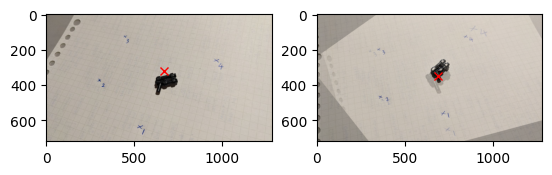

In [ ]:
# Ex 2.11
%matplotlib inline


def warpImage(im, H):
    """
    Warp an image using a homography matrix.
    """
    imWarp = cv2.warpPerspective(im, H, (im.shape[1], im.shape[0]))
    return imWarp


warped = warpImage(im1, H)

# Overlay images
plt.imshow(warped, alpha=0.5)
plt.imshow(im2, alpha=0.5)
plt.show()